In [ ]:
# Code copied from this link: http://krasserm.github.io/2020/12/12/gaussian-processes-sparse/
#install jax, jaxlib

In [1]:
import numpy as np
import jax.numpy as jnp
import jax.scipy as jsp
import matplotlib.pyplot as plt

from jax import random, jit, value_and_grad
from jax.config import config
from scipy.optimize import minimize

config.update("jax_enable_x64", True)
%matplotlib inline

# Training Dataset

In [3]:
def func(x):
    """Latent function."""
    return 1.0 * jnp.sin(x * 3 * jnp.pi) + \
           0.3 * jnp.cos(x * 9 * jnp.pi) + \
           0.5 * jnp.sin(x * 7 * jnp.pi)


# Number of training examples
n = 1000

# Number of inducing variables
m = 20

# Noise
sigma_y = 0.2

# Noisy training data
X = jnp.linspace(-1.0, 1.0, n).reshape(-1, 1)
y = func(X) + sigma_y * random.normal(random.PRNGKey(0), shape=(n, 1))

# Test data
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
f_true = func(X_test)

# Inducing inputs
X_m = jnp.linspace(-0.4, 0.4, m).reshape(-1, 1)

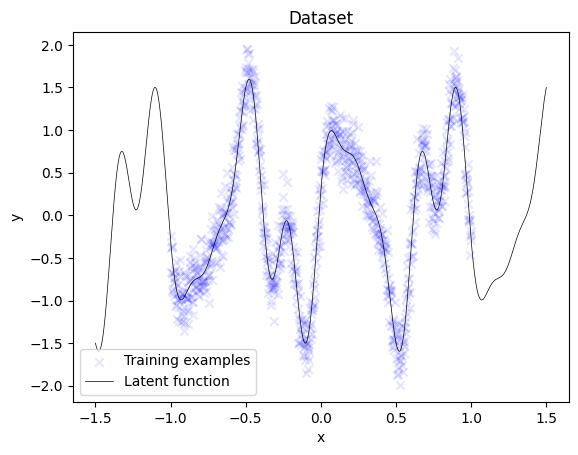

In [4]:
plt.scatter(X, y, label='Training examples', marker='x', color='blue', alpha=0.1)
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.title('Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

# Kernel

In [5]:
def kernel(X1, X2, theta):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: Array of m points (m, d).
        X2: Array of n points (n, d).
        theta: kernel parameters (2,)
    """

    sqdist = jnp.sum(X1 ** 2, 1).reshape(-1, 1) + jnp.sum(X2 ** 2, 1) - 2 * jnp.dot(X1, X2.T)
    return theta[1] ** 2 * jnp.exp(-0.5 / theta[0] ** 2 * sqdist)


def kernel_diag(d, theta):
    """
    Isotropic squared exponential kernel (computes diagonal elements only).
    """
    return jnp.full(shape=d, fill_value=theta[1] ** 2)

# Optimization

In [6]:
def jitter(d, value=1e-6):
    return jnp.eye(d) * value


def softplus(X):
    return jnp.log(1 + jnp.exp(X))


def softplus_inv(X):
    return jnp.log(jnp.exp(X) - 1)


def pack_params(theta, X_m):
    return jnp.concatenate([softplus_inv(theta), X_m.ravel()])


def unpack_params(params):
    return softplus(params[:2]), jnp.array(params[2:].reshape(-1, 1))


def nlb_fn(X, y, sigma_y):
    n = X.shape[0]

    def nlb(params):
        """
        Negative lower bound on log marginal likelihood.
        
        Args:
            params: kernel parameters `theta` and inducing inputs `X_m`
        """
        
        theta, X_m = unpack_params(params)

        K_mm = kernel(X_m, X_m, theta) + jitter(X_m.shape[0])
        K_mn = kernel(X_m, X, theta)

        L = jnp.linalg.cholesky(K_mm)  # m x m
        A = jsp.linalg.solve_triangular(L, K_mn, lower=True) / sigma_y  # m x n        
        AAT = A @ A.T  # m x m
        B = jnp.eye(X_m.shape[0]) + AAT  # m x m
        LB = jnp.linalg.cholesky(B)  # m x m
        c = jsp.linalg.solve_triangular(LB, A.dot(y), lower=True) / sigma_y  # m x 1

        # Equation (13)
        lb = - n / 2 * jnp.log(2 * jnp.pi)
        lb -= jnp.sum(jnp.log(jnp.diag(LB)))
        lb -= n / 2 * jnp.log(sigma_y ** 2)
        lb -= 0.5 / sigma_y ** 2 * y.T.dot(y)
        lb += 0.5 * c.T.dot(c)
        lb -= 0.5 / sigma_y ** 2 * jnp.sum(kernel_diag(n, theta))
        lb += 0.5 * jnp.trace(AAT)

        return -lb[0, 0]

    # nlb_grad returns the negative lower bound and 
    # its gradient w.r.t. params i.e. theta and X_m.
    nlb_grad = jit(value_and_grad(nlb))

    def nlb_grad_wrapper(params):
        value, grads = nlb_grad(params)
        # scipy.optimize.minimize cannot handle
        # JAX DeviceArray directly. a conversion
        # to Numpy ndarray is needed.
        return np.array(value), np.array(grads)

    return nlb_grad_wrapper

In [7]:
# Run optimization
res = minimize(fun=nlb_fn(X, y, sigma_y),
               x0=pack_params(jnp.array([1.0, 1.0]), X_m),
               method='L-BFGS-B',
               jac=True)

# Optimized kernel parameters and inducing inputs
theta_opt, X_m_opt = unpack_params(res.x)

In [ ]:
@jit
def phi_opt(theta, X_m, X, y, sigma_y):
    """Optimize mu_m and A_m using Equations (11) and (12)."""
    precision = (1.0 / sigma_y ** 2)

    K_mm = kernel(X_m, X_m, theta) + jitter(X_m.shape[0])
    K_mm_inv = jnp.linalg.inv(K_mm)
    K_nm = kernel(X, X_m, theta)
    K_mn = K_nm.T
    
    Sigma = jnp.linalg.inv(K_mm + precision * K_mn @ K_nm)
    
    mu_m = precision * (K_mm @ Sigma @ K_mn).dot(y)
    A_m = K_mm @ Sigma @ K_mm    
    
    return mu_m, A_m, K_mm_inv

mu_m_opt, A_m_opt, K_mm_inv = phi_opt(theta_opt, X_m_opt, X, y, sigma_y)

In [ ]:
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.scatter(X_m_opt, mu_m_opt, label='Inducing variables', c='m')
plt.title('Optimized inducing variables')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-1.5, 1.5)
plt.legend();

# Prediction

In [ ]:
@jit
def q(X_test, theta, X_m, mu_m, A_m, K_mm_inv):
    """
    Approximate posterior. 
    
    Computes mean and covariance of latent 
    function values at test inputs X_test.
    """
    
    K_ss = kernel(X_test, X_test, theta)
    K_sm = kernel(X_test, X_m, theta)
    K_ms = K_sm.T

    f_q = (K_sm @ K_mm_inv).dot(mu_m)
    f_q_cov = K_ss - K_sm @ K_mm_inv @ K_ms + K_sm @ K_mm_inv @ A_m @ K_mm_inv @ K_ms
    
    return f_q, f_q_cov

In [ ]:
f_test, f_test_cov = q(X_test, theta_opt, X_m_opt, mu_m_opt, A_m_opt, K_mm_inv)
f_test_var = np.diag(f_test_cov)
f_test_std = np.sqrt(f_test_var)

plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.plot(X_test, f_test, label='Prediction', c='b')
plt.fill_between(X_test.ravel(), 
                 f_test.ravel() + 2 * f_test_std, 
                 f_test.ravel() - 2 * f_test_std,
                 label='Epistemic uncertainty',
                 color='r', alpha=0.1)
plt.title('Approximate posterior')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(None, 3.0)
plt.legend();